结论1: 近三年来，文化历史、科技创新与经济发展是国内新闻报道的主要主题，体现出我国的发展重心与战略。
       而一些关注度高的重大突发事件，如疫情、核废水排放，也会大量出现在新闻报道中，也体现了大众的关注取向。

使用的数据分析方法: 根据7k+条新闻数据的标题、正文纯文本，经过jieba分词后训练LDA模型，进行主题提取

为加快文本读取以分词过程，采用了多进程

In [1]:
import jsonlines
import jieba
from tqdm import tqdm  # 进度条用
from gensim import corpora, models
import pickle
from bs4 import BeautifulSoup
import re
from multiprocessing import Pool, cpu_count

documents = []
stopword_list = []

def process_line(line):
    global stopword_list
    title = line.get('title', '')
    content = line.get('content', '')
    id = int(line.get('url', '')[-8:])
    time = line.get('time', '')
    tags = line.get('tags', {})
    tag_str = ''
    for tag in tags:
        tag_str += tag[1:]
    content = BeautifulSoup(content, 'html.parser').text
    text = title + ' ' + content + ' ' + tag_str
    words = jieba.cut(text)
    return {'id': id, 'content': [word for word in list(words) if word not in stopword_list and len(word) > 1], 'title': title[:2], 'time': time[:7]}

def main():
    global documents

    jsonl_file_path = "sorted_selected.jsonl"
    total_lines = sum(1 for _ in open(jsonl_file_path, 'r', encoding='utf-8'))

    num_processes = cpu_count()
    pool = Pool(processes=num_processes)

    with jsonlines.open(jsonl_file_path) as reader:
        tasks = [line for line in reader]

        with tqdm(total=total_lines, desc="Processing data") as pbar:
            for result in pool.imap(process_line, tasks):
                documents.append(result)
                pbar.update()

    pool.close()
    pool.join()

if __name__ == "__main__":
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as f:
        stopword_list = [word[:-1] for word in f.readlines()]
    stopword_list = set(stopword_list)
    # print(stopword_list)

    main()
    documents = sorted(documents, key=lambda item: item['id'])
    # print([doc['time'] for doc in documents])
    documents = [doc['content'] for doc in documents]
    print(len(documents))

    dictionary = corpora.Dictionary(documents)
    print('saving dictionary.pkl')
    with open('dictionary_selected.pkl', 'wb') as f:
        pickle.dump(dictionary, f)

    corpus = [dictionary.doc2bow(doc) for doc in documents]
    print(len(corpus))
    print('saving corpus.pkl')
    with open('corpus_selected.pkl', 'wb') as f:
        pickle.dump(corpus, f)

    num_topics = 7
    print('training lda model...')
    lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics)
    print('saving lda model...')
    lda_model.save('lda_selected.model')

    for topic_id in range(num_topics):
        print(f"Topic {topic_id}: {lda_model.print_topic(topic_id, topn=10)}")

    doc_idx = 1515 # 这是一篇关于日本排放核废水的报道 测试用
    doc_topics = lda_model[corpus[doc_idx]]
    print(f"Document's topic distribution: {doc_topics}")


Processing data:   0%|          | 0/7043 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cac

7043
saving dictionary.pkl
7043
saving corpus.pkl
training lda model...
saving lda model...
Topic 0: 0.004*"中国" + 0.003*"生活" + 0.003*"文化" + 0.002*"孩子" + 0.002*"问题" + 0.002*"世界" + 0.002*"电影" + 0.002*"故事" + 0.002*"作品" + 0.002*"历史"
Topic 1: 0.005*"文化" + 0.004*"上海" + 0.004*"中国" + 0.003*"历史" + 0.002*"城市" + 0.002*"建筑" + 0.002*"品牌" + 0.002*"发展" + 0.002*"俄罗斯" + 0.002*"展览"
Topic 2: 0.017*"日本" + 0.009*"核污染" + 0.007*"福岛" + 0.006*"中国" + 0.004*"安全" + 0.004*"食盐" + 0.004*"产品" + 0.004*"进口" + 0.003*"市场" + 0.003*"美国"
Topic 3: 0.010*"发展" + 0.007*"中国" + 0.005*"国家" + 0.005*"建设" + 0.004*"市场" + 0.004*"企业" + 0.004*"工作" + 0.004*"公司" + 0.004*"经济" + 0.003*"项目"
Topic 4: 0.003*"医院" + 0.003*"患者" + 0.003*"研究" + 0.002*"治疗" + 0.002*"公司" + 0.002*"技术" + 0.002*"美国" + 0.002*"医生" + 0.002*"问题" + 0.002*"病例"
Topic 5: 0.006*"公司" + 0.004*"AI" + 0.004*"中国" + 0.004*"数据" + 0.003*"学生" + 0.003*"技术" + 0.003*"平台" + 0.003*"企业" + 0.003*"孩子" + 0.003*"游戏"
Topic 6: 0.007*"工作" + 0.006*"服务" + 0.003*"人员" + 0.003*"信息" + 0.003*"网络" + 0.003*"安全"

通过上面的主题结果可以看到，国内新闻的常见话题出现频率较高，国外新闻更多集中于美国、日本。这一点也与我爬取数据时针对23年8月这段时间增加相对爬取量有关。

之后，我将所有新闻对所有主题的相关性进行统计，按照相关性最大值对新闻按主题分类，再将每类新闻各做词云统计，得到了下面的结果。

len(corpus) = 7043
Topic 0: 0.007*"公司" + 0.006*"中国" + 0.006*"市场" + 0.004*"企业" + 0.004*"增长" + 0.003*"发展" + 0.003*"同比" + 0.003*"产品" + 0.003*"集团" + 0.003*"项目"
Topic 1: 0.007*"文化" + 0.005*"中国" + 0.004*"发展" + 0.003*"历史" + 0.003*"生活" + 0.003*"城市" + 0.002*"作品" + 0.002*"艺术" + 0.002*"时代" + 0.002*"上海"
Topic 2: 0.008*"发展" + 0.005*"工作" + 0.005*"中国" + 0.004*"国家" + 0.004*"建设" + 0.004*"服务" + 0.003*"企业" + 0.003*"问题" + 0.003*"日本" + 0.003*"合作"
Topic 3: 0.007*"日本" + 0.005*"核污染" + 0.003*"福岛" + 0.003*"孩子" + 0.003*"问题" + 0.002*"研究" + 0.002*"生活" + 0.002*"中国" + 0.002*"工作" + 0.002*"医院"
Topic 4: 0.005*"病例" + 0.004*"工作" + 0.004*"疫情" + 0.003*"上海" + 0.003*"新冠" + 0.003*"确诊" + 0.003*"感染者" + 0.003*"发展" + 0.003*"无症状" + 0.003*"监委"
Topic 5: 0.004*"安全" + 0.004*"工作" + 0.004*"诈骗" + 0.002*"网络" + 0.002*"中国" + 0.002*"犯罪" + 0.002*"信息" + 0.002*"人员" + 0.002*"问题" + 0.002*"保护"
Topic 6: 0.005*"中国" + 0.003*"金砖" + 0.003*"国家" + 0.003*"服务" + 0.003*"记者" + 0.002*"信息" + 0.002*"网络" + 0.002*"提供" + 0.002*"视频" + 0.002*"人员"

Topic 0:
len(doc_i

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\li_ha\AppData\Local\Temp\jieba.cache


got plain_text
finished jieba.cut()


Loading model cost 0.577 seconds.
Prefix dict has been built successfully.


Topic 1:
len(doc_id_to_wordcloud) = 887
got plain_text
finished jieba.cut()
Topic 2:
len(doc_id_to_wordcloud) = 1457
got plain_text
finished jieba.cut()
Topic 3:
len(doc_id_to_wordcloud) = 1210
got plain_text
finished jieba.cut()
Topic 4:
len(doc_id_to_wordcloud) = 499
got plain_text
finished jieba.cut()
Topic 5:
len(doc_id_to_wordcloud) = 578
got plain_text
finished jieba.cut()
Topic 6:
len(doc_id_to_wordcloud) = 1014
got plain_text
finished jieba.cut()


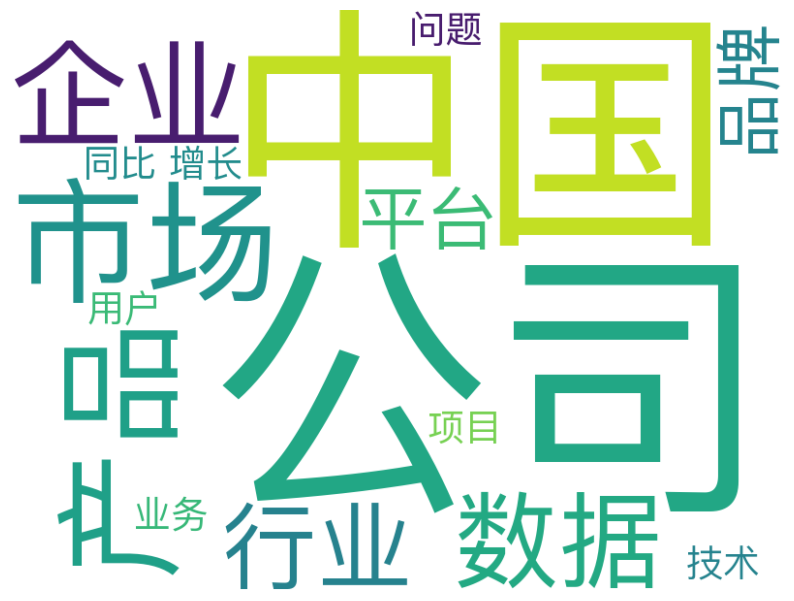

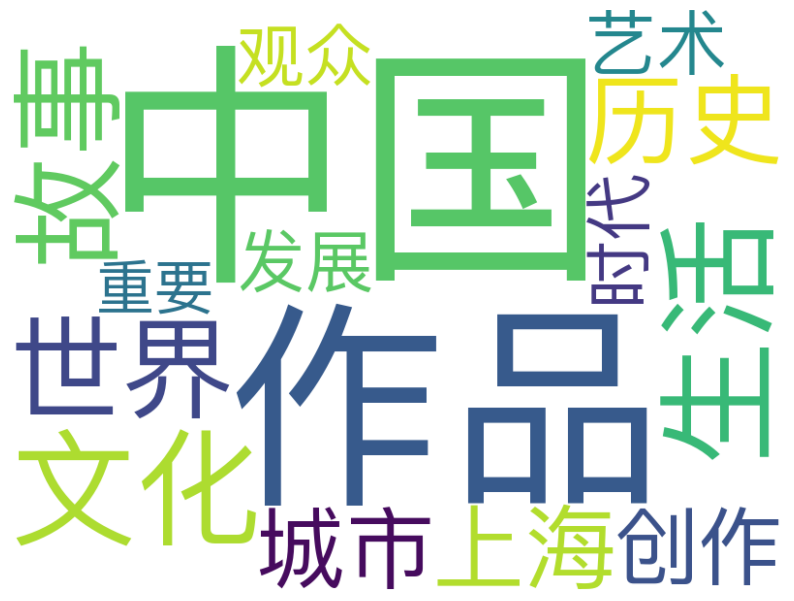

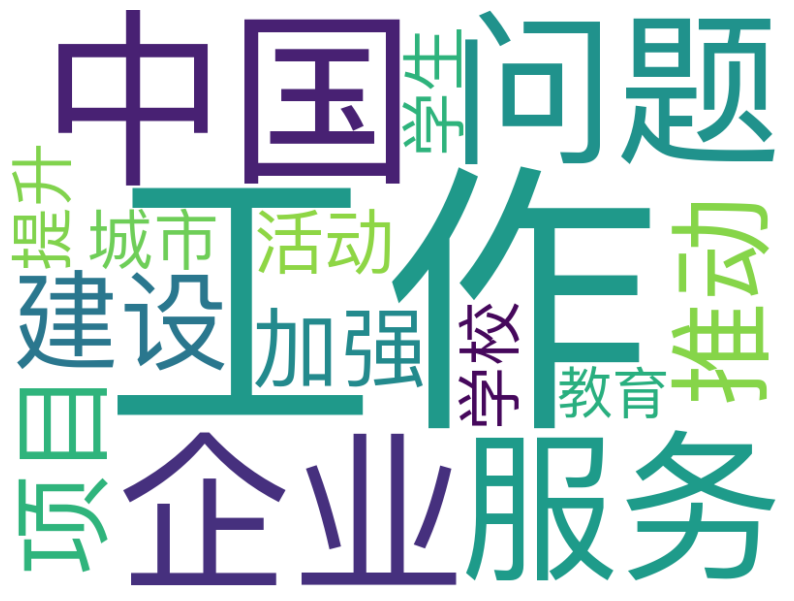

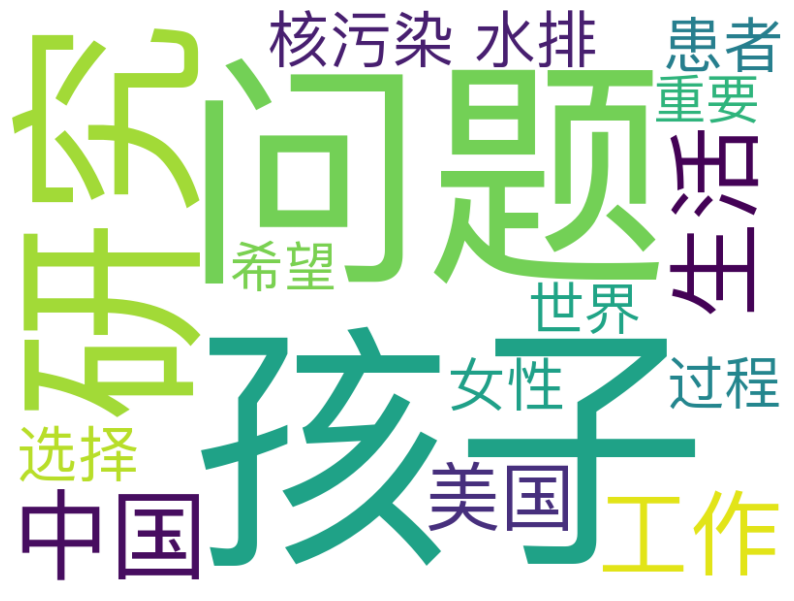

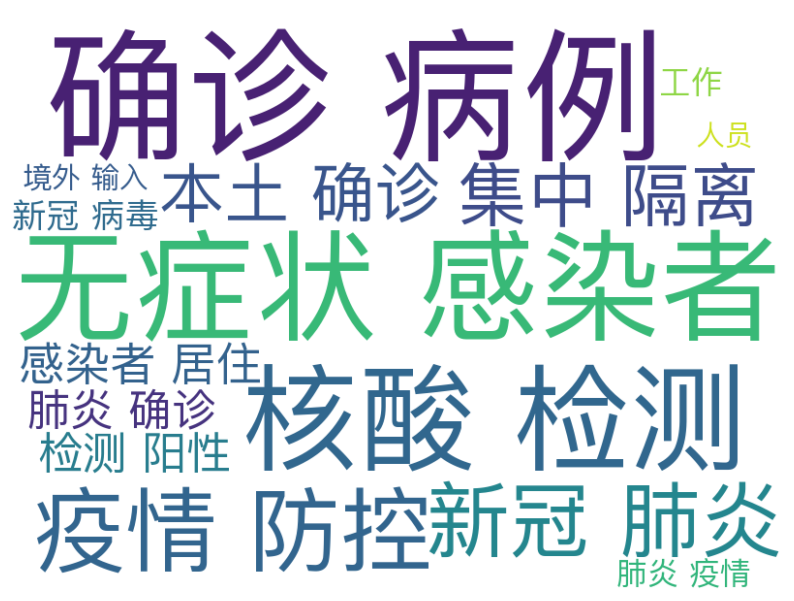

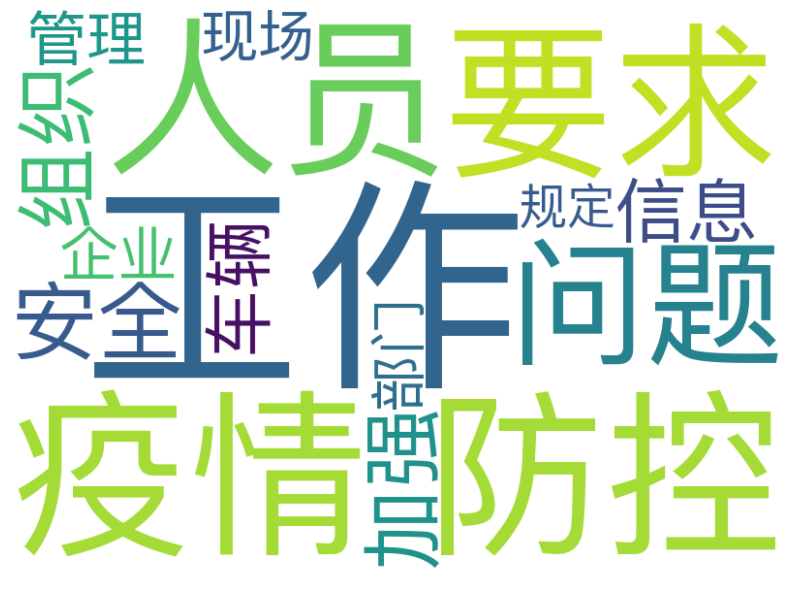

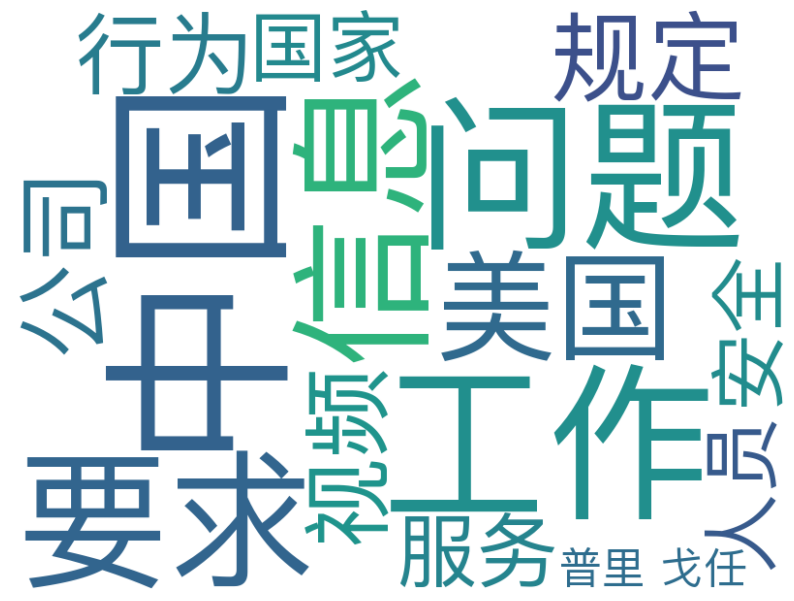

In [4]:
from gensim import models
import pickle
import json
import jieba
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

with open('cn_stopwords.txt', 'r', encoding='utf-8') as f:
    stopword_list = [word[:-1] for word in f.readlines()]
stopword_list = set(stopword_list)

def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser').text
    return soup

def read_id_docs(doc_id_to_wordcloud):
    titles = []
    contents = []
    with open('sorted_selected.jsonl', 'r', encoding='utf-8') as f:
        for line_index, line in enumerate(f):
            if line_index in doc_id_to_wordcloud:
                data = json.loads(line)
                titles.append(data['title'])
                contents.append(data['content'])
    plain_texts = [extract_text_from_html(content) for content in contents]
    plain_text = ' '.join(titles + plain_texts)
    print('got plain_text')
    jwords_string = jieba.cut(plain_text)
    print('finished jieba.cut()')
    final_words = []
    for word in jwords_string:
        if word not in stopword_list and len(word) > 1:
            final_words.append(word)
    words_string = ' '.join(final_words)
    return words_string

with open('corpus_selected.pkl', 'rb') as f:
    corpus = pickle.load(f)
print("len(corpus) =", len(corpus))

lda_model = models.LdaModel.load('lda_selected.model')
num_topics = lda_model.num_topics

for topic_id in range(num_topics):
    print(f"Topic {topic_id}: {lda_model.print_topic(topic_id)}")
print()

docs_topics = [lda_model[corpus[idx]] for idx in range(len(corpus))]
docs_topic = []
for doc_topics in docs_topics:
    max_prob = 0
    max_topic = -1
    for topic_id, topic_prob in doc_topics:
        if topic_prob > max_prob:
            max_prob = topic_prob
            max_topic = topic_id
    if max_topic == -1:
        raise ValueError('max_topic == -1')
    docs_topic.append(max_topic)

for topic_id_to_wordcloud in range(num_topics):
    print(f"Topic {topic_id_to_wordcloud}:")
    doc_id_to_wordcloud = []
    for doc_id, doc_topic in enumerate(docs_topic):
        if doc_topic == topic_id_to_wordcloud:
            doc_id_to_wordcloud.append(doc_id)
    print("len(doc_id_to_wordcloud) =", len(doc_id_to_wordcloud))
    words_string = read_id_docs(doc_id_to_wordcloud)
    wordcloud = WordCloud(
        font_path='PingFang-SC-Regular.ttf',
        background_color='white',
        width=800,
        height=600,
        max_words=15
    ).generate(words_string)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'wordcloud_{topic_id_to_wordcloud}.png')

通过这些词云分析，我们可以看到：

topic0主要关于公司企业等民营经济；

topic1主要关于国内民众生活方面，偏向日常；

topic2主要关于中国建设问题，通过词云判断，对应新闻应该是类似官方文件式的发展规划；

topic3主要关于日本核废水排放问题；

topic4主要关于新冠疫情信息等；

topic5主要关于疫情期间企业人员管理要求等问题；

topic6主要关于国际关系的问题，尤其是中美关系



我还使用了t-SNE算法，对主题分类进行了验证: 

corpus loaded
[[0.01194908 0.01194191 0.0119323  0.55044258 0.01194022 0.0119352
  0.38985869]
 [0.         0.         0.         0.99750239 0.         0.
  0.        ]
 [0.99594122 0.         0.         0.         0.         0.
  0.        ]]
tsne ready


/tmp/ipykernel_991650/2114607736.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_topics)


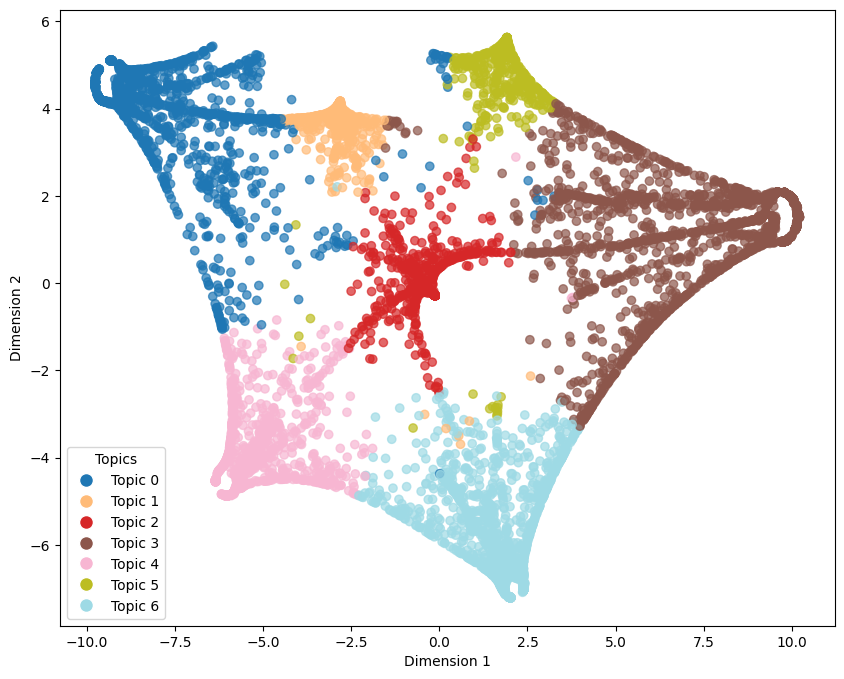

In [30]:
from gensim import models
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

lda_model = models.LdaModel.load('lda_selected.model')
num_topics = lda_model.num_topics

with open('corpus_selected.pkl', 'rb') as f:
    corpus = pickle.load(f)
print('corpus loaded')

docs_topics_weights = [lda_model[corpus[idx]] for idx in range(len(corpus))]
result_matrix = np.zeros((len(corpus), num_topics))
for i in range(len(docs_topics_weights)):
    for x, y in docs_topics_weights[i]:
        result_matrix[i][x] = y
print(result_matrix[:3])

perplexity = 1000
tsne = TSNE(n_components=2, perplexity=perplexity)
x_tsne = tsne.fit_transform(result_matrix)
print('tsne ready')

most_probable_topics = [max(doc, key=lambda item: item[1])[0] for doc in docs_topics_weights]

color_map = plt.cm.get_cmap('tab20', num_topics)
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=most_probable_topics, cmap=color_map, marker='o', alpha=0.7)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10, label=f"Topic {i}") for i in range(num_topics)]
plt.legend(handles=handles, title="Topics", loc='best')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig(f't-sne-{perplexity}.png')

可以看到，上图的不同话题的新闻对应的簇有较为明显的分布，也呈现了特殊的拓扑形状


结论2: 不同时间的新闻主题占比有着明显的变化，一定程度上可以体现国内新闻报道的关注重点的变化。

分析方法: 使用分好类的新闻，按照月份进行主题类别统计，代码如下

[5, 2, 6, 6, 4, 3, 2, 5, 2, 2, 4, 6, 1, 0, 6, 0, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 0, 0, 3, 0, 1, 6, 1, 4, 3, 3, 3, 3, 3, 1, 3, 3, 5, 5, 3, 2, 0, 5, 3, 3, 3, 3, 3, 0, 1, 0, 2, 3, 3, 2, 1, 2, 0, 0, 2, 6, 6, 4, 3, 2, 0, 1, 2, 0, 1, 4, 1, 3, 3, 5, 2, 6, 6, 5, 2, 2, 1, 2, 2, 0, 0, 4, 2, 3, 3, 1, 3, 2, 2, 2, 5, 1, 1, 0, 3, 0, 2, 0, 6, 6, 1, 4, 5, 2, 2, 5, 5, 6, 5, 6, 2, 3, 1, 2, 3, 2, 6, 2, 6, 4, 3, 1, 1, 1, 5, 2, 2, 1, 4, 4, 4, 4, 4, 6, 2, 3, 3, 3, 2, 5, 2, 6, 5, 2, 2, 1, 2, 2, 5, 4, 3, 2, 3, 4, 1, 3, 1, 1, 0, 1, 3, 0, 3, 6, 0, 3, 3, 3, 3, 3, 3, 3, 1, 2, 6, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 6, 5, 3, 5, 6, 5, 1, 2, 3, 3, 3, 0, 3, 2, 3, 0, 1, 2, 1, 3, 1, 1, 6, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 1, 0, 2, 2, 2, 2, 2, 4, 2, 4, 1, 4, 2, 2, 2, 3, 2, 6, 0, 2, 3, 2, 2, 3, 3, 6, 0, 1, 2, 0, 4, 1, 1, 0, 1, 4, 6, 0, 4, 0, 6, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 4, 2, 5, 1, 3, 3, 0, 2, 0, 0, 3, 2, 3, 3, 3, 3, 0, 0, 0, 1, 0, 0, 3, 0, 2, 1, 3, 1, 3, 2, 2, 5, 0, 1, 3, 1, 4, 2, 4, 5, 5, 0, 3, 1, 5, 3, 0, 0, 6, 3, 

C:\Users\li_ha\AppData\Local\Temp\ipykernel_6292\567547244.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 4))


2022-08: [28, 22, 27, 21, 9, 15, 26]
2022-09: [21, 21, 31, 20, 6, 16, 9]
2022-10: [9, 10, 18, 13, 24, 12, 10]
2022-11: [23, 11, 16, 11, 18, 6, 12]
2022-12: [13, 15, 21, 20, 14, 7, 9]
2023-01: [12, 11, 25, 15, 7, 5, 14]
2023-02: [16, 14, 20, 9, 5, 8, 13]
2023-03: [22, 16, 32, 22, 1, 4, 11]
2023-04: [30, 16, 31, 16, 6, 7, 11]
2023-05: [27, 13, 25, 13, 12, 6, 14]
2023-06: [14, 14, 26, 27, 3, 5, 15]
2023-07: [20, 16, 19, 16, 2, 10, 18]
2023-08: [569, 257, 429, 409, 86, 183, 383]


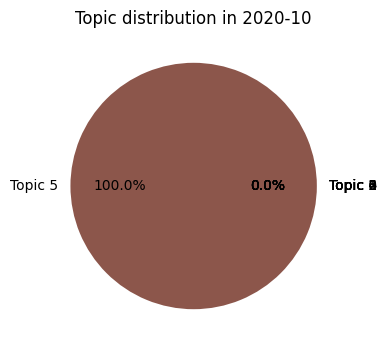

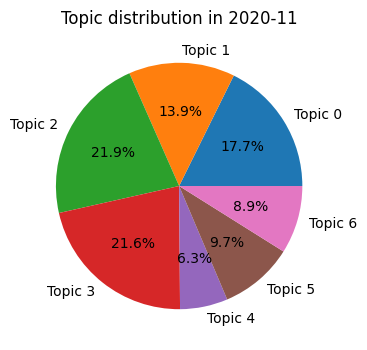

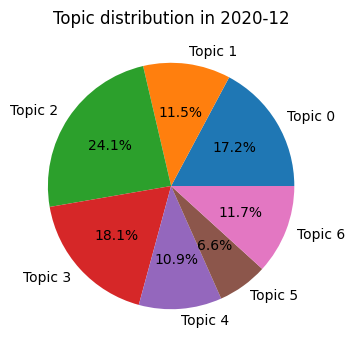

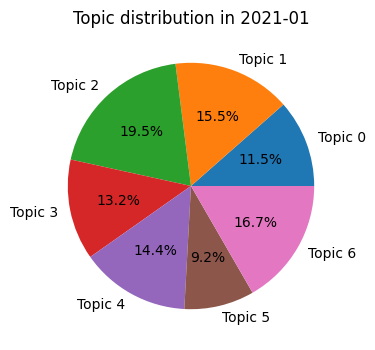

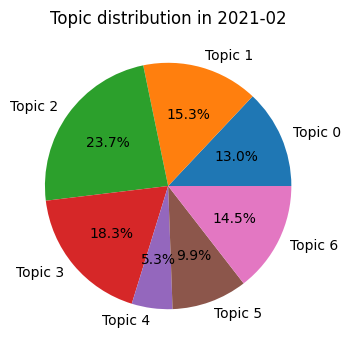

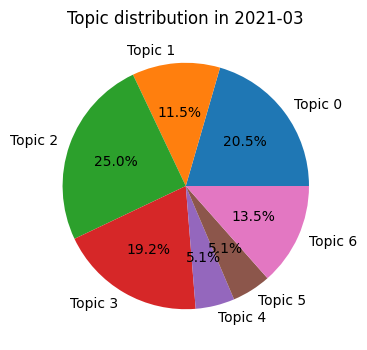

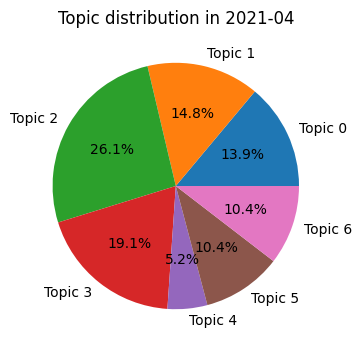

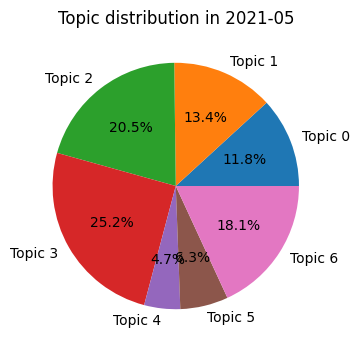

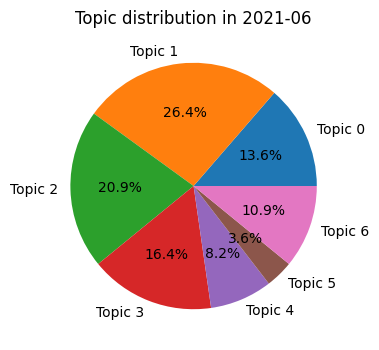

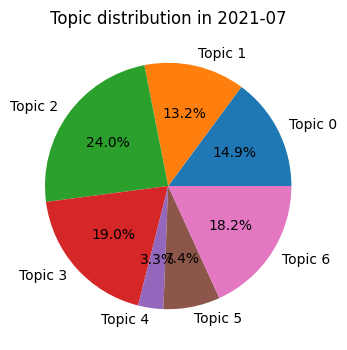

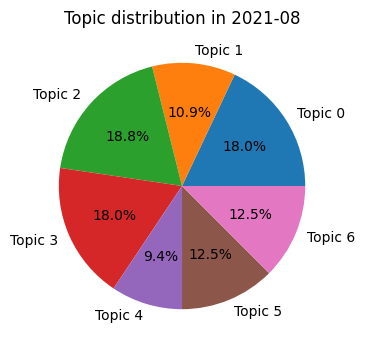

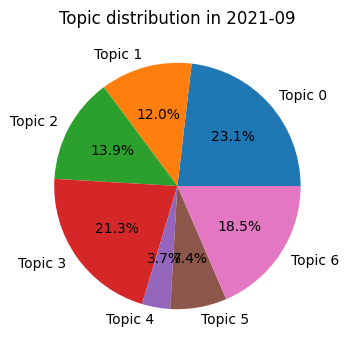

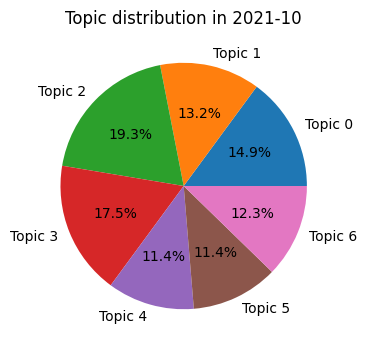

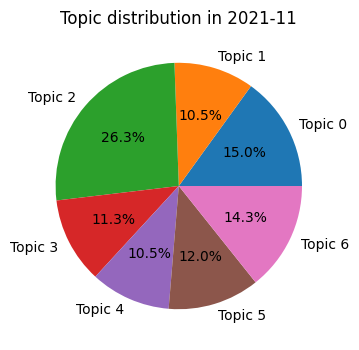

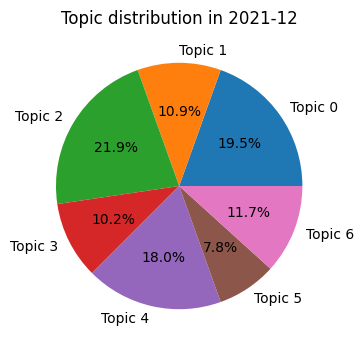

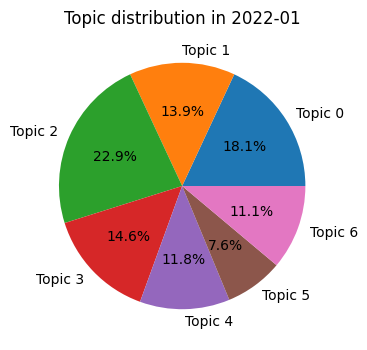

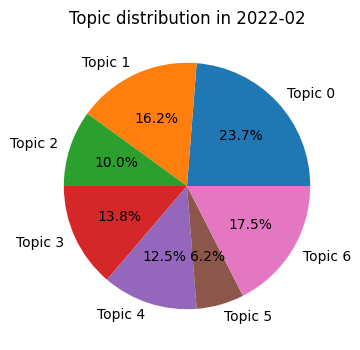

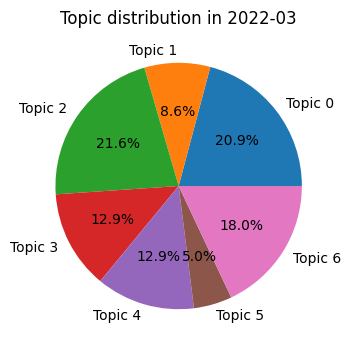

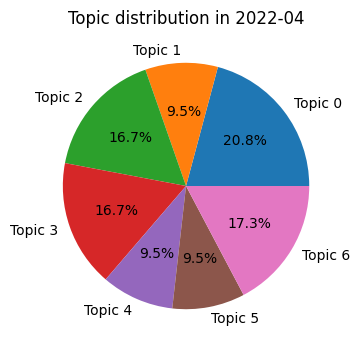

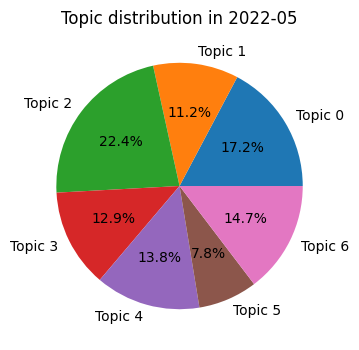

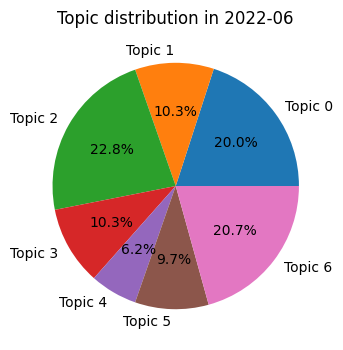

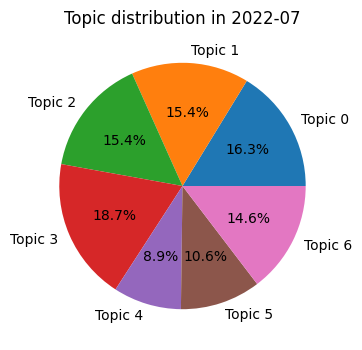

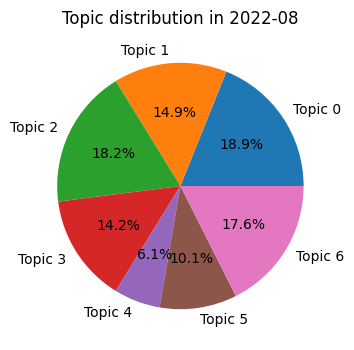

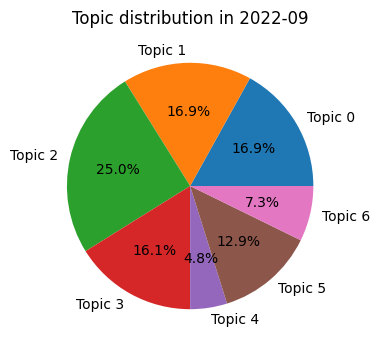

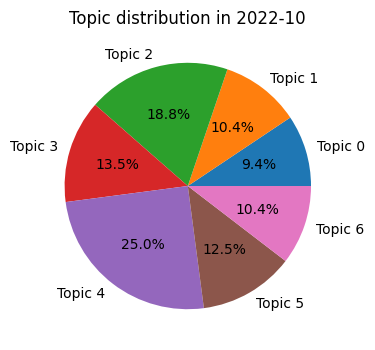

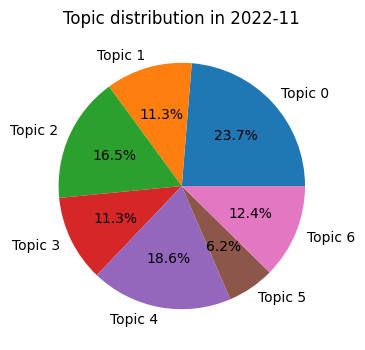

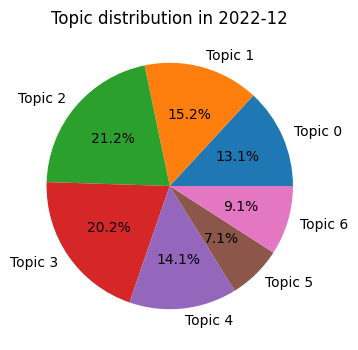

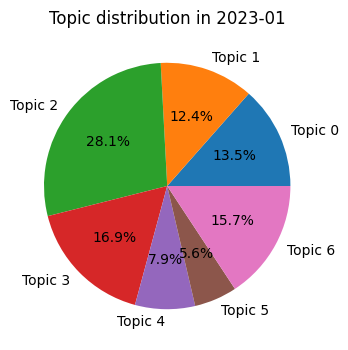

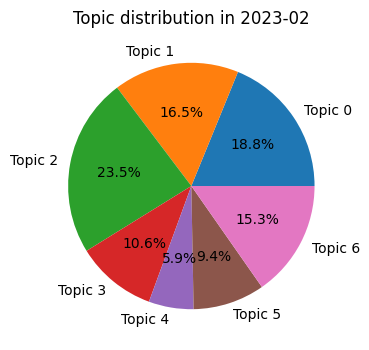

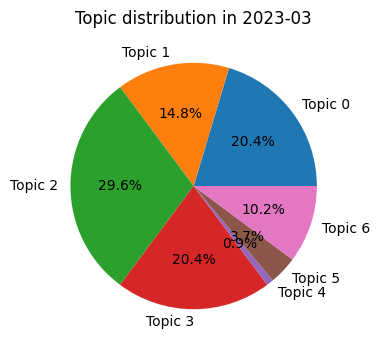

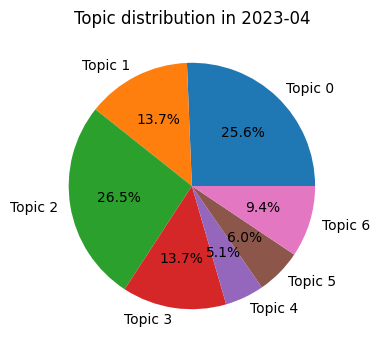

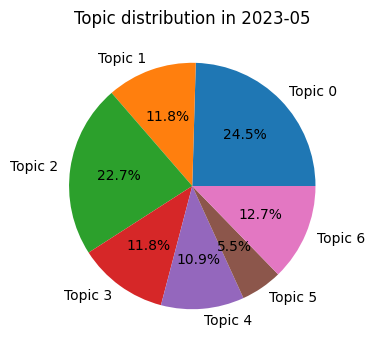

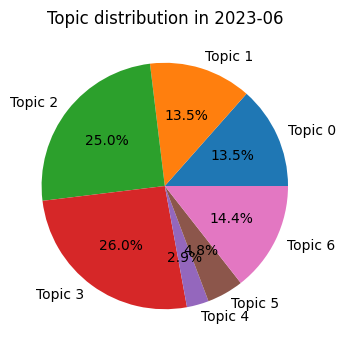

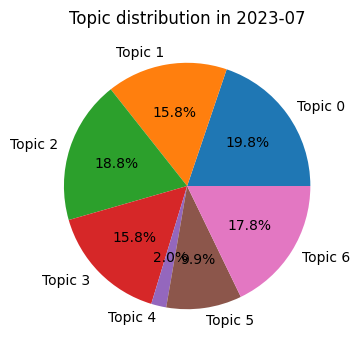

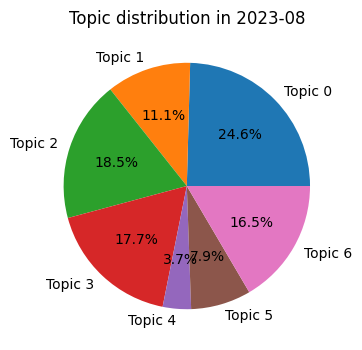

In [13]:
print(docs_topic)

time_stamp = []
with open('sorted_selected.jsonl', 'r', encoding='utf-8') as f:
    for line_index, line in enumerate(f):
        data = json.loads(line)
        time_stamp.append(data['time'][:7])
print(len(docs_topic), len(time_stamp))

time_topic_dict = {}
for i in range(len(docs_topic)):
    if time_stamp[i] not in time_topic_dict:
        time_topic_dict[time_stamp[i]] = []
    time_topic_dict[time_stamp[i]].append(docs_topic[i])
time_topic_dict = dict(sorted(time_topic_dict.items(), key=lambda item: item[0]))
print(time_topic_dict)

import matplotlib.pyplot as plt 
for month, values in time_topic_dict.items():
    counts = [0 for _ in range(num_topics)]
    for value in values:
        counts[value] += 1
    print(f"{month}: {counts}")

    plt.figure(figsize=(4, 4))
    plt.pie(counts, labels=[f"Topic {i}" for i in range(num_topics)], autopct='%1.1f%%')
    plt.title(f"Topic distribution in {month}")
    plt.savefig(f"pie-{month}.png")

上面这些图最明显的就是topic4和5，两者均是新冠疫情相关。在22年底，疫情解封结束，相关新闻暴增（2022-11&2022-12），之后进入23年，疫情相关新闻基本消失。

因此，利用主题分布对时间序列的变化一定程度上可以分析出国内新闻报道的关注重点的变化。

结论3: 以时间序列分析新闻的情感得分可以验证整体国内外的发展形势

In [13]:
from snownlp import SnowNLP
import json
from bs4 import BeautifulSoup

scores_for_months = {}

with open('sorted_selected.jsonl', 'r', encoding='utf-8') as f:
    for line_index, line in enumerate(f):
        data = json.loads(line)
        plain_text = BeautifulSoup(data['content'], 'html.parser').text
        sentences = plain_text.split('。')
        sentences = [sentence.strip() for sentence in sentences]
        sentences = [sentence for sentence in sentences if sentence != '']
        score = count = 0
        for sentence in sentences:
            score += SnowNLP(sentence).sentiments
            count += 1
        if count == 0:
            continue
        score = score / count
        month = data['time'][:7]
        if month not in scores_for_months:
            scores_for_months[month] = 0
            scores_for_months[month+'_count'] = 0
        scores_for_months[month] += score
        scores_for_months[month+'_count'] += 1

for k in list(scores_for_months.keys()):
    if k.endswith('_count'):
        continue
    scores_for_months[k] = scores_for_months[k] / scores_for_months[k+'_count']
for k in list(scores_for_months.keys()):
    if k.endswith('_count'):
        scores_for_months.pop(k)
scores_for_months = dict(sorted(list(scores_for_months.items()), key=lambda x: x[1]))
print(scores_for_months)

{'2022-10': 0.6345155740548769, '2022-11': 0.6435814449692178, '2022-06': 0.6493889156313827, '2022-03': 0.6621737165219425, '2021-11': 0.6645185232749856, '2023-08': 0.6672922125500091, '2022-05': 0.6696013536891667, '2022-08': 0.6738454769430292, '2023-05': 0.6775702181499403, '2021-01': 0.678005363925446, '2022-12': 0.6791594452492147, '2021-08': 0.6792562868696872, '2023-02': 0.6799908042959584, '2021-09': 0.680125699045628, '2023-07': 0.6836792581177461, '2021-10': 0.6858906907464251, '2022-04': 0.6870232694626384, '2023-04': 0.6913474373302442, '2023-01': 0.6962455322224111, '2022-02': 0.6966896142515845, '2021-12': 0.6992780719026872, '2020-11': 0.699690308296458, '2022-01': 0.7016278838850277, '2023-06': 0.701734426726979, '2022-07': 0.7051338490792955, '2021-04': 0.7081689260008549, '2020-12': 0.7095167657194984, '2021-05': 0.7114454322024607, '2022-09': 0.7119238370321546, '2021-06': 0.7179637827621397, '2021-02': 0.7183511155184591, '2021-03': 0.7212366716254646, '2021-07': 

{'2020-11': 0.699690308296458, '2020-12': 0.7095167657194984, '2021-01': 0.678005363925446, '2021-02': 0.7183511155184591, '2021-03': 0.7212366716254646, '2021-04': 0.7081689260008549, '2021-05': 0.7114454322024607, '2021-06': 0.7179637827621397, '2021-07': 0.7282785275189485, '2021-08': 0.6792562868696872, '2021-09': 0.680125699045628, '2021-10': 0.6858906907464251, '2021-11': 0.6645185232749856, '2021-12': 0.6992780719026872, '2022-01': 0.7016278838850277, '2022-02': 0.6966896142515845, '2022-03': 0.6621737165219425, '2022-04': 0.6870232694626384, '2022-05': 0.6696013536891667, '2022-06': 0.6493889156313827, '2022-07': 0.7051338490792955, '2022-08': 0.6738454769430292, '2022-09': 0.7119238370321546, '2022-10': 0.6345155740548769, '2022-11': 0.6435814449692178, '2022-12': 0.6791594452492147, '2023-01': 0.6962455322224111, '2023-02': 0.6799908042959584, '2023-03': 0.7356760347601623, '2023-04': 0.6913474373302442, '2023-05': 0.6775702181499403, '2023-06': 0.701734426726979, '2023-07': 

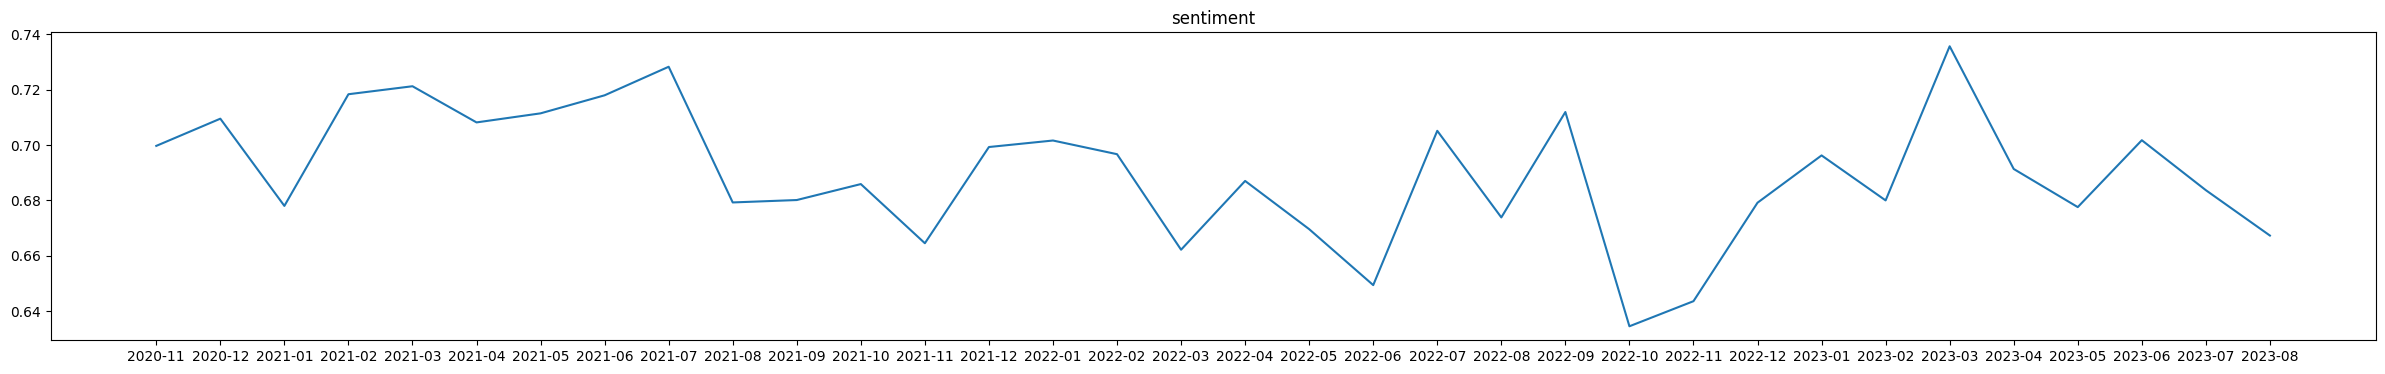

In [29]:
# use the value from last code cell
scores_for_months = {'2022-10': 0.6345155740548769, '2022-11': 0.6435814449692178, '2022-06': 0.6493889156313827, '2022-03': 0.6621737165219425, '2021-11': 0.6645185232749856, '2023-08': 0.6672922125500091, '2022-05': 0.6696013536891667, '2022-08': 0.6738454769430292, '2023-05': 0.6775702181499403, '2021-01': 0.678005363925446, '2022-12': 0.6791594452492147, '2021-08': 0.6792562868696872, '2023-02': 0.6799908042959584, '2021-09': 0.680125699045628, '2023-07': 0.6836792581177461, '2021-10': 0.6858906907464251, '2022-04': 0.6870232694626384, '2023-04': 0.6913474373302442, '2023-01': 0.6962455322224111, '2022-02': 0.6966896142515845, '2021-12': 0.6992780719026872, '2020-11': 0.699690308296458, '2022-01': 0.7016278838850277, '2023-06': 0.701734426726979, '2022-07': 0.7051338490792955, '2021-04': 0.7081689260008549, '2020-12': 0.7095167657194984, '2021-05': 0.7114454322024607, '2022-09': 0.7119238370321546, '2021-06': 0.7179637827621397, '2021-02': 0.7183511155184591, '2021-03': 0.7212366716254646, '2021-07': 0.7282785275189485, '2023-03': 0.7356760347601623, '2020-10': 0.9999871406195237}
scores_for_months = dict(sorted(list(scores_for_months.items()), key=lambda x: x[0])[1:]) #去掉2020-10 因为这月只有一条新闻 没有分析意义
print(scores_for_months)
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 4))
plt.plot(list(scores_for_months.keys()), list(scores_for_months.values()))
plt.title('sentiment')
plt.savefig('sentiment.png')

可以看到，近三年整体新闻报道的情感比较积极

但疫情期间情感大体呈下降趋势（如果数据足够多我相信趋势会更明显）

而疫情结束后，情感趋势回升

推测2023-08较低的原因是国内经济下行及日本排放核废水相关新闻较多导致